In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import os

In [14]:
root_path = "../../data/ablation/baseline&ablation-11.30"
output_fig_path = '../..//figs/ablation/all'

datasets = {"agnews": 1, "mnli": 0, "yahoo": 5, "yelp-full": 0}
all_client_num_in_total_list = {"agnews": 100, "yahoo": 1000, "yelp-full": 1000, "mnli": 1000}
alphas = {"agnews": 1, "yahoo": 0, "yelp-full": 0, "mnli": 0}
gammas = {"agnews": 0.001, "yahoo": 0.001, "yelp-full": 0.001, "mnli": 100}
full_set_acc= {"agnews": 0.93, "yahoo": 0.78, "yelp-full": 0.7, "mnli": 0.85}
seed = 6

# roberta-base
filenames_list = {
    "agnews": ["new_token_cpu_vote_stale_aug_100_conver_0_limit_0_fedpet_64_32_roberta-large_5_1_filter_-1.log","bitfit_fedpet_roberta-large_train_examples_64_f_100_n_1_k_5_filter_-1.log", 
    "bitfit+filter_fedpet_roberta-large_train_examples_64_f_100_n_1_k_5_filter_0.1.log",
    "bitfit+filter+curriculum_fedpet_roberta-large_train_examples_64_f_5_n_1_k_5_filter_0.1.log"],
    "mnli": ["new_token_cpu_vote_stale_aug_100_conver_0_limit_0_fedpet_64_32_roberta-large_5_1_filter_-1.log","bitfit_fedpet_roberta-large_train_examples_64_f_100_n_1_k_5_filter_-1.log", 
    "bitfit+filter_fedpet_roberta-large_train_examples_64_f_100_n_1_k_5_filter_0.2.log",
    "bitfit+filter+curriculum_fedpet_roberta-large_train_examples_64_f_5_n_1_k_5_filter_0.2.log"],
    "yahoo": ["new_token_cpu_vote_stale_aug_100_conver_0_limit_0_fedpet_64_32_roberta-large_5_1_filter_-1.log","bitfit_fedpet_roberta-large_train_examples_64_f_100_n_1_k_5_filter_-1.log", 
    "bitfit+filter_fedpet_roberta-large_train_examples_64_f_100_n_1_k_5_filter_0.1.log",
    "bitfit+filter+curriculum_fedpet_roberta-large_train_examples_64_f_5_n_1_k_5_filter_0.1.log"],
    "yelp-full": ["new_token_cpu_vote_stale_aug_100_conver_0_limit_0_fedpet_64_32_roberta-large_5_1_filter_-1.log","bitfit_fedpet_roberta-large_train_examples_64_f_100_n_1_k_5_filter_-1.log", 
    "bitfit+filter_fedpet_roberta-large_train_examples_64_f_100_n_1_k_5_filter_0.5.log",
    "bitfit+filter+curriculum_fedpet_roberta-large_train_examples_64_f_5_n_1_k_5_filter_0.5.log"],
}

# TX2: Real per batch latency, bs = 4, msl = 256.
train_latency_list = {"tx2+bitfit": 1 , "tx2+full": 2}
infer_latency_list = {"tx2+bitfit": 0.5, "tx2+full": 1 }
communication_latency_list = {"bitfit": 1000 * 2 / 1000 / 1, "full": 1000 * 2 / 1}

# # RPI: Fake per batch latency, bs = 4, msl = 256. latency = tx2 * 15 
# train_latency_list = {"tx2+bitfit": 1 * 15, "tx2+full": 2 * 15}
# infer_latency_list = {"tx2+bitfit": 0.5 * 15, "tx2+full": 1 *15 }
# communication_latency_list = {"bitfit": 1000 * 2 / 1000 / 1, "full": 1000 * 2 / 1}

labels = ["origin","bitfit", "bitfit+filter", "bitfit+filter+curriculum"]

In [15]:
# plot hyper-para.
colors=['r','g', 'b','y','c','m','k'] * 100
full_set_acc= {"agnews": 0.93, "yahoo": 0.78, "yelp-full": 0.7, "mnli": 0.85}

/Users/cdq/Desktop/opensource/FedPrompt/data/ablation/baseline&ablation-11.30/agnews/all_100/seed_6/pattern_1/alpha_1_beta_0_gamma_0.001/new_token_cpu_vote_stale_aug_100_conver_0_limit_0_fedpet_64_32_roberta-large_5_1_filter_-1.log
max accuracy is 0.8790789473684211, round is 53
            0
0    0.347763
1    0.625395
2    0.569868
3    0.768289
4    0.732237
..        ...
145  0.867105
146  0.864079
147  0.864474
148  0.868289
149  0.869211

[150 rows x 1 columns]
range(0, 50)
[[0.37393888]
 [0.67246746]
 [0.61276174]
 [0.82611771]
 [0.78735144]
 [0.79909451]
 [0.92076967]
 [0.85752688]
 [0.87662705]
 [0.93095642]
 [0.93675722]
 [0.93534239]
 [0.91426146]
 [0.84493492]
 [0.89558574]
 [0.9081777 ]
 [0.89983022]
 [0.90096208]
 [0.9040747 ]
 [0.90336729]
 [0.92317487]
 [0.92430673]
 [0.90534805]
 [0.9172326 ]
 [0.92529711]
 [0.92020374]
 [0.90718732]
 [0.94397284]
 [0.91341256]
 [0.91482739]
 [0.88950198]
 [0.93647425]
 [0.9286927 ]
 [0.92996604]
 [0.93718166]
 [0.90464063]
 [0.9265704

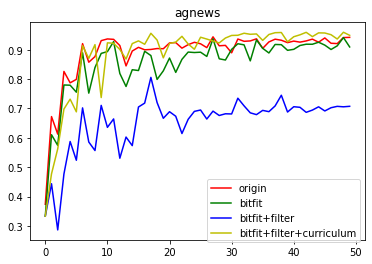

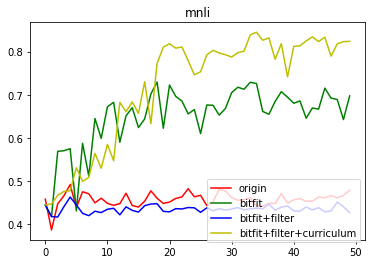

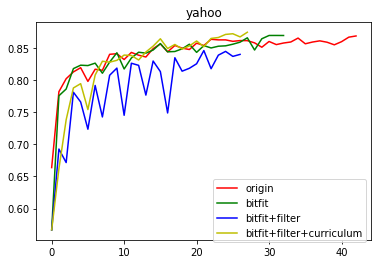

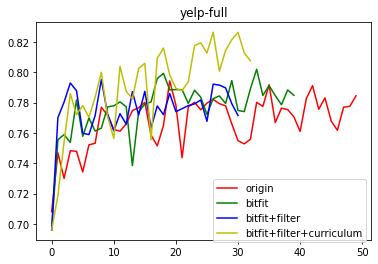

In [16]:
# round to accuracy
# i=0
acc_list = {"agnews": [], "mnli": [], "yahoo": [], "yelp-full": []}
round_list = {"agnews": [], "mnli": [], "yahoo": [], "yelp-full": []}
acc_threshold_list = {"agnews": 0.9, "mnli": 0.72, "yahoo": 0.85, "yelp-full": 0.79}

for dataset in filenames_list:

    log_root_path = os.path.join(root_path,f"{dataset}/all_{all_client_num_in_total_list[dataset]}/seed_{seed}/pattern_{datasets[dataset]}/alpha_{alphas[dataset]}_beta_0_gamma_{gammas[dataset]}")

    filenames = filenames_list[dataset]

    fig = plt.figure()
    plt.title(dataset)
    for filename in filenames:
        log_path = os.path.join(log_root_path,filename)

        iter = 1000
        phrase = 'aggregated model performance is'
        with open(log_path) as f:
            f = f.readlines()
        df = pd.DataFrame(data=None, index = range(iter), columns = range(1))
        for line in f:
            if phrase in line:
                gen = int(re.findall(r'Gen (.+?) ',line)[0])
                
                acc = float(re.findall(r': ?(\d+\.\d+)',line)[0])
                df[0][gen]=acc

        df = df.dropna(axis=0, how='any') 

        this_max_acc = np.max(df[0])
        idx = [df[0].to_list().index(x) for x in df[0] if x == this_max_acc][0]
        print(log_path)
        print(f"max accuracy is {this_max_acc}, round is {idx}")
        print(df)
        acc_list[dataset].append(this_max_acc)
        round_list[dataset].append(idx)
        
        iter = min(len(df.index),50)
        y_mean = []
        for j in range(iter):
            y = np.array(df.iloc[j])

            y_mean.append(pd.DataFrame(y).dropna().mean())
            # plt.scatter(j, y)
        print(range(iter))
        print(np.array(y_mean)/full_set_acc[dataset])
        print(colors[filenames.index(filename)])

        plt.plot(range(iter),np.array(y_mean)/full_set_acc[dataset],label=labels[filenames.index(filename)],color=colors[filenames.index(filename)])
    fig.legend(loc="lower right",bbox_to_anchor=(0.9,0.1),bbox_transform=fig.transFigure)
    fig.savefig(os.path.join(output_fig_path, f"{dataset}-11.30-round2accuracy.pdf"))

In [17]:
acc_list

{'agnews': [0.8790789473684211,
  0.8755263157894737,
  0.7494736842105263,
  0.8925],
 'mnli': [0.41793173713703513,
  0.6450331125827815,
  0.3933774834437086,
  0.7394803871625064],
 'yahoo': [0.67765,
  0.6782666666666667,
  0.6599333333333334,
  0.6821666666666667],
 'yelp-full': [0.55606, 0.56138, 0.55662, 0.57848]}

10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0
10000.0


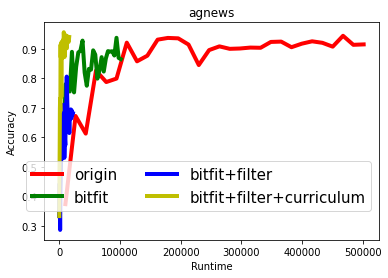

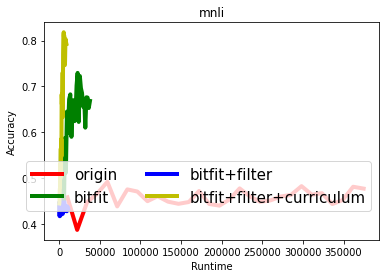

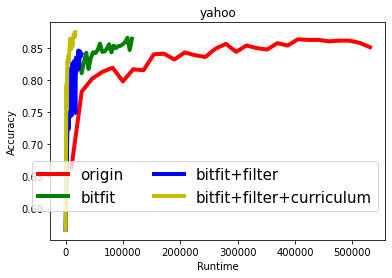

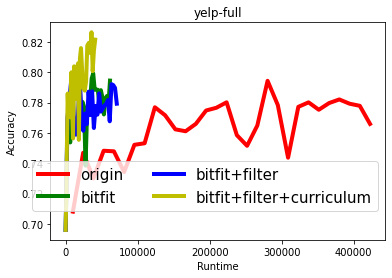

In [18]:
# time to accuracy  take max acc as the final acc
t = 0   
acc_list = {"agnews": [], "mnli": [], "yahoo": [], "yelp-full": []}
runtime_list = {"agnews": [], "mnli": [], "yahoo": [], "yelp-full": []}     
acc_threshold_list = {"agnews": 0.9, "mnli": 0.72, "yahoo": 0.85, "yelp-full": 0.79} # relative accuracy

for dataset in filenames_list:

    log_root_path = os.path.join(root_path,f"{dataset}/all_{all_client_num_in_total_list[dataset]}/seed_{seed}/pattern_{datasets[dataset]}/alpha_{alphas[dataset]}_beta_0_gamma_{gammas[dataset]}")

    filenames = filenames_list[dataset]

    fig = plt.figure()
    plt.title(dataset)
    plt.xlabel("Runtime")
    plt.ylabel("Accuracy")
    for filename in filenames:
        log_path = os.path.join(log_root_path,filename)
        if not os.path.exists(log_path):
            print(f"{log_path} not exists")
            continue

        iter = 1000
        phrase = 'train data'
        with open(log_path) as f:
            f = f.readlines()
        df = pd.DataFrame(data=None, index = range(iter), columns = range(1))
        runtime = []
        train_runtime = []
        infer_runtime = []
        time_stamp = 0
        train_time_stamp = 0
        infer_time_stamp = 0

        for line in f:
            if phrase in line:
                line_idx = f.index(line)
                
                train_info = f[line_idx]
                infer_info = f[line_idx + 1]
                
                if filenames.index(filename) <= 0:
                    # TX2: train, 1s/sample, infer, 0.5s/sample, no comm. because bit fit is parameter efficient.
                    train_time = sum(list(map(int, re.findall(r'\d+', train_info.split("Gen")[1])))[1:]) * train_latency_list["tx2+full"]
                    infer_time = sum(list(map(int, re.findall(r'\d+', infer_info.split("Gen")[1])))[1:]) * infer_latency_list["tx2+full"]
                else:
                    # TX2: train, 1s/sample, infer, 0.5s/sample, no comm. because bit fit is parameter efficient.
                    train_time = sum(list(map(int, re.findall(r'\d+', train_info.split("Gen")[1])))[1:]) * train_latency_list["tx2+bitfit"]
                    infer_time = sum(list(map(int, re.findall(r'\d+', infer_info.split("Gen")[1])))[1:]) * infer_latency_list["tx2+bitfit"]
                
                if filenames.index(filename) <= 0:
                    comm_time = communication_latency_list["full"] * 5
                else:
                    comm_time = communication_latency_list["bitfit"] * 5
                print(comm_time)
                time_stamp = time_stamp + train_time + infer_time + comm_time # elasped time of all clients / energy consumption
                train_time_stamp = train_time + train_time_stamp
                infer_time_stamp = infer_time + infer_time_stamp

                runtime.append(time_stamp)
                train_runtime.append(train_time_stamp)
                infer_runtime.append(infer_time_stamp)
            if 'aggregated model performance is' in line: 
                gen = int(re.findall(r'Gen (.+?) ',line)[0])
                
                acc = float(re.findall(r': ?(\d+\.\d+)',line)[0])
                df[0][gen]=acc

        df = df.dropna(axis=0, how='any') # any 只要有 nan 就会删掉。 all　是必须全是nan才删除; 0: 行；1：列
        if df.empty:
            print(f"Bug: {log_path}")
    
        this_max_acc = np.max(df[0])
        idx = [df[0].to_list().index(x) for x in df[0] if x == this_max_acc][0]
        print(log_path)
        # print(f"max accuracy is {this_max_acc}, runtime is {runtime[idx]}")
        acc_list[dataset].append(this_max_acc)

        if this_max_acc >= full_set_acc[dataset] * acc_threshold_list[dataset]:
            idx = [df[0].to_list().index(x) for x in df[0] if x > full_set_acc[dataset] * acc_threshold_list[dataset]][0]
            runtime_list[dataset].append(runtime[idx])
        # df.to_csv("/Users/cdq/Desktop/opensource/FedPrompt/data/softlabel/agnews_aug_fedpet_128_32_roberta-large.csv")
        iter = min(len(df.index),30)
        y_mean = []
        for j in range(iter):
            y = np.array(df.iloc[j])

            y_mean.append(pd.DataFrame(y).dropna().mean())
            # plt.scatter(j, y)
        print(len(runtime),len(list(map(float, y_mean))))
        plt.plot(runtime[:len(y_mean)],np.array(y_mean)/full_set_acc[dataset],label=labels[filenames.index(filename)],color=colors[filenames.index(filename)],linewidth=4)
    fig.legend(loc="lower right",bbox_to_anchor=(0.9,0.2),bbox_transform=fig.transFigure,ncol=2,fontsize=15)
    fig.savefig(os.path.join(output_fig_path, f"{dataset}-11.30-time2accuracy.pdf"))

In [19]:
runtime_list

{'agnews': [908954.0, 167834.0, 12336.0, 42174.5],
 'mnli': [59212.0, 114823.0, 1240.0, 33115.0],
 'yahoo': [764188.0, 123663.0, 22259.0, 16678.0],
 'yelp-full': [280450.0, 70146.0, 19654.0, 35934.0]}

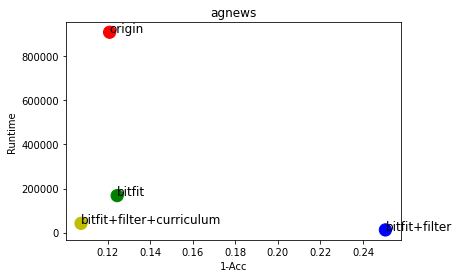

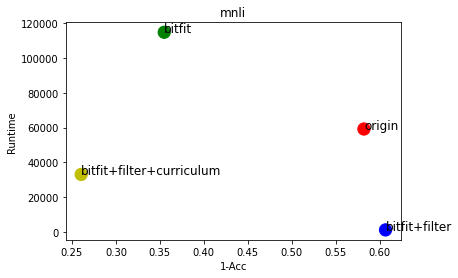

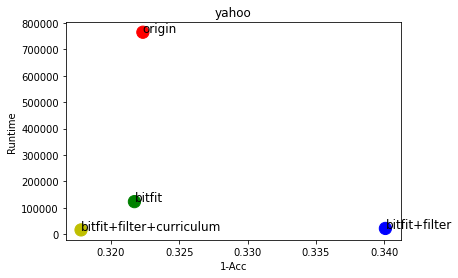

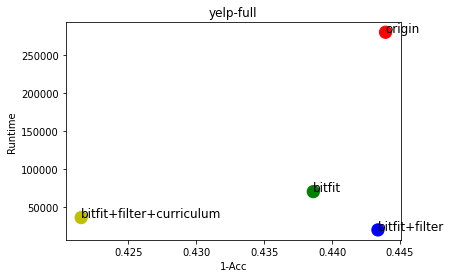

In [20]:
c=0
for dataset in datasets:
    fig = plt.figure()
    plt.title(f"{dataset}")
    plt.xlabel("1-Acc")
    plt.ylabel("Runtime")
    plt.scatter(1- np.array(acc_list[dataset]), np.array(runtime_list[dataset]),s=150,color=colors[:len(acc_list[dataset])])
    for idx in range(len(acc_list[dataset])):
        plt.text(1-acc_list[dataset][idx], runtime_list[dataset][idx], labels[idx], fontsize=12)
    plt.savefig(os.path.join(output_fig_path, f"sactter-{dataset}.pdf"))
    c=c+1

In [21]:
runtime_list

{'agnews': [908954.0, 167834.0, 12336.0, 42174.5],
 'mnli': [59212.0, 114823.0, 1240.0, 33115.0],
 'yahoo': [764188.0, 123663.0, 22259.0, 16678.0],
 'yelp-full': [280450.0, 70146.0, 19654.0, 35934.0]}

2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0

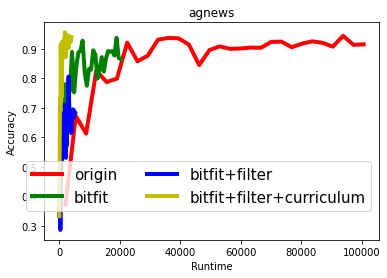

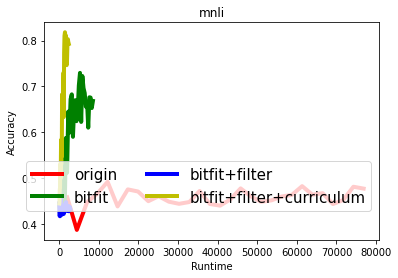

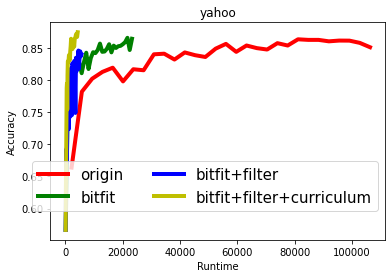

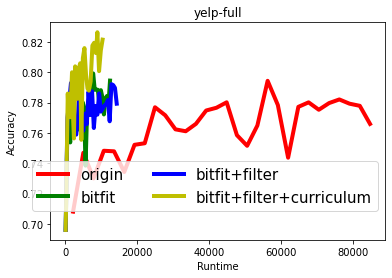

In [26]:
# time to accuracy  take acc of threshold as the final acc
t = 0   
acc_list = {"agnews": [], "mnli": [], "yahoo": [], "yelp-full": []}
runtime_list = {"agnews": [], "mnli": [], "yahoo": [], "yelp-full": []}     

acc_threshold = 0.8
for dataset in filenames_list:

    log_root_path = os.path.join(root_path,f"{dataset}/all_{all_client_num_in_total_list[dataset]}/seed_{seed}/pattern_{datasets[dataset]}/alpha_{alphas[dataset]}_beta_0_gamma_{gammas[dataset]}")

    filenames = filenames_list[dataset]

    fig = plt.figure()
    plt.title(dataset)
    plt.xlabel("Runtime")
    plt.ylabel("Accuracy")
    for filename in filenames:
        log_path = os.path.join(log_root_path,filename)
        if not os.path.exists(log_path):
            print(f"{log_path} not exists")
            continue

        iter = 1000
        phrase = 'train data'
        with open(log_path) as f:
            f = f.readlines()
        df = pd.DataFrame(data=None, index = range(iter), columns = range(1))
        runtime = []
        train_runtime = []
        infer_runtime = []
        time_stamp = 0
        train_time_stamp = 0
        infer_time_stamp = 0

        for line in f:
            if phrase in line:
                line_idx = f.index(line)
                
                train_info = f[line_idx]
                infer_info = f[line_idx + 1]
                
                train_samples = list(map(int, re.findall(r'\d+', train_info.split("Gen")[1])))[1:]
                infer_samples = list(map(int, re.findall(r'\d+', infer_info.split("Gen")[1])))[1:]

                if filenames.index(filename) <= 0:
                    # TX2: train, 1s/sample, infer, 0.5s/sample
                    train_time = np.max(train_samples) * train_latency_list["tx2+full"] if len(train_samples) > 0 else 0
                    infer_time = np.max(infer_samples) * infer_latency_list["tx2+full"] if len(infer_samples) > 0 else 0
                else:
                    # TX2: train, 1s/sample, infer, 0.5s/sample
                    train_time = np.max(train_samples) * train_latency_list["tx2+bitfit"] if len(train_samples) > 0 else 0
                    infer_time = np.max(infer_samples) * infer_latency_list["tx2+bitfit"] if len(infer_samples) > 0 else 0
                
                if filenames.index(filename) <= 0:
                    comm_time = communication_latency_list["full"]
                else:
                    comm_time = communication_latency_list["bitfit"]
                print(comm_time)
                time_stamp = time_stamp + train_time + infer_time + comm_time # elasped time of all clients / energy consumption
                train_time_stamp = train_time + train_time_stamp
                infer_time_stamp = infer_time + infer_time_stamp

                runtime.append(time_stamp)
                train_runtime.append(train_time_stamp)
                infer_runtime.append(infer_time_stamp)
            if 'aggregated model performance is' in line: 
                gen = int(re.findall(r'Gen (.+?) ',line)[0])
                
                acc = float(re.findall(r': ?(\d+\.\d+)',line)[0])
                df[0][gen]=acc

        df = df.dropna(axis=0, how='any') # any 只要有 nan 就会删掉。 all　是必须全是nan才删除; 0: 行；1：列
        if df.empty:
            print(f"Bug: {log_path}")
    
        this_max_acc = np.max(df[0])
        
        print(log_path)
        # print(f"max accuracy is {this_max_acc}, runtime is {runtime[idx]}")
        acc_list[dataset].append(this_max_acc)
        if this_max_acc >= full_set_acc[dataset] * acc_threshold:
            idx = [df[0].to_list().index(x) for x in df[0] if x > full_set_acc[dataset] * acc_threshold][0]
            runtime_list[dataset].append(runtime[idx]/60)
        # df.to_csv("/Users/cdq/Desktop/opensource/FedPrompt/data/softlabel/agnews_aug_fedpet_128_32_roberta-large.csv")
        iter = min(len(df.index),30)
        y_mean = []
        for j in range(iter):
            y = np.array(df.iloc[j])

            y_mean.append(pd.DataFrame(y).dropna().mean())
            # plt.scatter(j, y)
        print(len(runtime),len(list(map(float, y_mean))))
        plt.plot(runtime[:len(y_mean)],np.array(y_mean)/full_set_acc[dataset],label=labels[filenames.index(filename)],color=colors[filenames.index(filename)],linewidth=4)
    fig.legend(loc="lower right",bbox_to_anchor=(0.9,0.2),bbox_transform=fig.transFigure,ncol=2,fontsize=15)
    fig.savefig(os.path.join(output_fig_path, f"{dataset}-11.30-time2accuracy.pdf"))

In [27]:
runtime_list

{'agnews': [205.3, 71.16666666666667, 52.15, 8.933333333333334],
 'mnli': [21.983333333333334],
 'yahoo': [155.2, 41.0, 29.366666666666667, 11.9],
 'yelp-full': [235.03333333333333, 30.566666666666666]}